<a href="https://colab.research.google.com/github/ben45123/AWS-Lambda-Research/blob/main/ComputerVisionFinalProject/SkinTone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Cell 1: Import Required Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import shutil

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [17]:
# Cell 2: Organize Dataset Structure
import kagglehub
from sklearn.model_selection import train_test_split
import shutil
import os

# Download latest version
path = "/kaggle/input/skin-tone-classification-dataset"  # Using the path from your output
print("Path to dataset files:", path)

# Create necessary directory structure
os.makedirs("./skin_complexion_dataset/train/Black", exist_ok=True)
os.makedirs("./skin_complexion_dataset/train/Brown", exist_ok=True)
os.makedirs("./skin_complexion_dataset/train/White", exist_ok=True)
os.makedirs("./skin_complexion_dataset/validation/Black", exist_ok=True)
os.makedirs("./skin_complexion_dataset/validation/Brown", exist_ok=True)
os.makedirs("./skin_complexion_dataset/validation/White", exist_ok=True)
os.makedirs("./skin_complexion_dataset/test/Black", exist_ok=True)
os.makedirs("./skin_complexion_dataset/test/Brown", exist_ok=True)
os.makedirs("./skin_complexion_dataset/test/White", exist_ok=True)

# Train directory and class directories are capitalized based on your output
train_path = os.path.join(path, "train")
black_dir = os.path.join(train_path, "Black")
brown_dir = os.path.join(train_path, "Brown")
white_dir = os.path.join(train_path, "White")

# Function to organize dataset
def organize_dataset(source_dir, class_name):
    print(f"Processing {class_name} class from {source_dir}")
    if os.path.exists(source_dir):
        # Get all images with the specific extension
        image_files = [f for f in os.listdir(source_dir)
                      if f.endswith('.jpg.chip.jpg')]
        print(f"Found {len(image_files)} images for {class_name}")

        # Split into train (70%), validation (15%), and test (15%)
        train_files, temp_files = train_test_split(image_files, test_size=0.3, random_state=42)
        val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

        # Copy files to appropriate directories
        for file in train_files:
            src = os.path.join(source_dir, file)
            dst = os.path.join("./skin_complexion_dataset/train", class_name, file)
            shutil.copy(src, dst)

        for file in val_files:
            src = os.path.join(source_dir, file)
            dst = os.path.join("./skin_complexion_dataset/validation", class_name, file)
            shutil.copy(src, dst)

        for file in test_files:
            src = os.path.join(source_dir, file)
            dst = os.path.join("./skin_complexion_dataset/test", class_name, file)
            shutil.copy(src, dst)

        print(f"Class {class_name}: {len(train_files)} training, {len(val_files)} validation, {len(test_files)} test images")
    else:
        print(f"Directory {source_dir} does not exist")

# Process each class directory
organize_dataset(black_dir, "Black")
organize_dataset(brown_dir, "Brown")
organize_dataset(white_dir, "White")

# Count files in each directory to verify
print("\nVerifying dataset organization:")
print(f"Training set:")
print(f"  Black: {len(os.listdir('./skin_complexion_dataset/train/Black'))} images")
print(f"  Brown: {len(os.listdir('./skin_complexion_dataset/train/Brown'))} images")
print(f"  White: {len(os.listdir('./skin_complexion_dataset/train/White'))} images")
print(f"Validation set:")
print(f"  Black: {len(os.listdir('./skin_complexion_dataset/validation/Black'))} images")
print(f"  Brown: {len(os.listdir('./skin_complexion_dataset/validation/Brown'))} images")
print(f"  White: {len(os.listdir('./skin_complexion_dataset/validation/White'))} images")
print(f"Test set:")
print(f"  Black: {len(os.listdir('./skin_complexion_dataset/test/Black'))} images")
print(f"  Brown: {len(os.listdir('./skin_complexion_dataset/test/Brown'))} images")
print(f"  White: {len(os.listdir('./skin_complexion_dataset/test/White'))} images")

Path to dataset files: /kaggle/input/skin-tone-classification-dataset
Processing Black class from /kaggle/input/skin-tone-classification-dataset/train/Black
Found 499 images for Black
Class Black: 349 training, 75 validation, 75 test images
Processing Brown class from /kaggle/input/skin-tone-classification-dataset/train/Brown
Found 500 images for Brown
Class Brown: 350 training, 75 validation, 75 test images
Processing White class from /kaggle/input/skin-tone-classification-dataset/train/White
Found 500 images for White
Class White: 350 training, 75 validation, 75 test images

Verifying dataset organization:
Training set:
  Black: 349 images
  Brown: 350 images
  White: 350 images
Validation set:
  Black: 75 images
  Brown: 75 images
  White: 75 images
Test set:
  Black: 75 images
  Brown: 75 images
  White: 75 images


In [18]:
# Cell 3: Define Preprocessing Functions
def detect_face(image):
    """
    Detect face in an image and return the face region.

    Args:
        image: Input image (BGR format from OpenCV)

    Returns:
        Face region if found, otherwise the original image
    """
    # Load pre-trained face detector from OpenCV
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Convert to grayscale for face detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # If faces are found, return the first face region
    if len(faces) > 0:
        x, y, w, h = faces[0]
        face_region = image[y:y+h, x:x+w]
        return face_region
    else:
        # If no face is detected, return the original image
        return image

def preprocess_image(image_path, target_size=(IMG_SIZE, IMG_SIZE)):
    """
    Load image, detect face, and preprocess for model input.

    Args:
        image_path: Path to the image file
        target_size: Target size for model input

    Returns:
        Preprocessed image ready for model input
    """
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image at {image_path}")

    # Detect face
    face = detect_face(image)

    # Resize to target size
    face_resized = cv2.resize(face, target_size)

    # Convert BGR to RGB (TensorFlow uses RGB)
    face_rgb = cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB)

    # Normalize pixel values to [0, 1]
    face_normalized = face_rgb / 255.0

    return face_normalized

In [19]:
# Cell 4: Set Up Data Generators with Augmentation
# Define data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# For validation and testing, we only rescale
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Get class indices and print them
class_indices = train_generator.class_indices
print("Class indices:", class_indices)

Found 1049 images belonging to 3 classes.
Found 225 images belonging to 3 classes.
Found 225 images belonging to 3 classes.
Class indices: {'Black': 0, 'Brown': 1, 'White': 2}


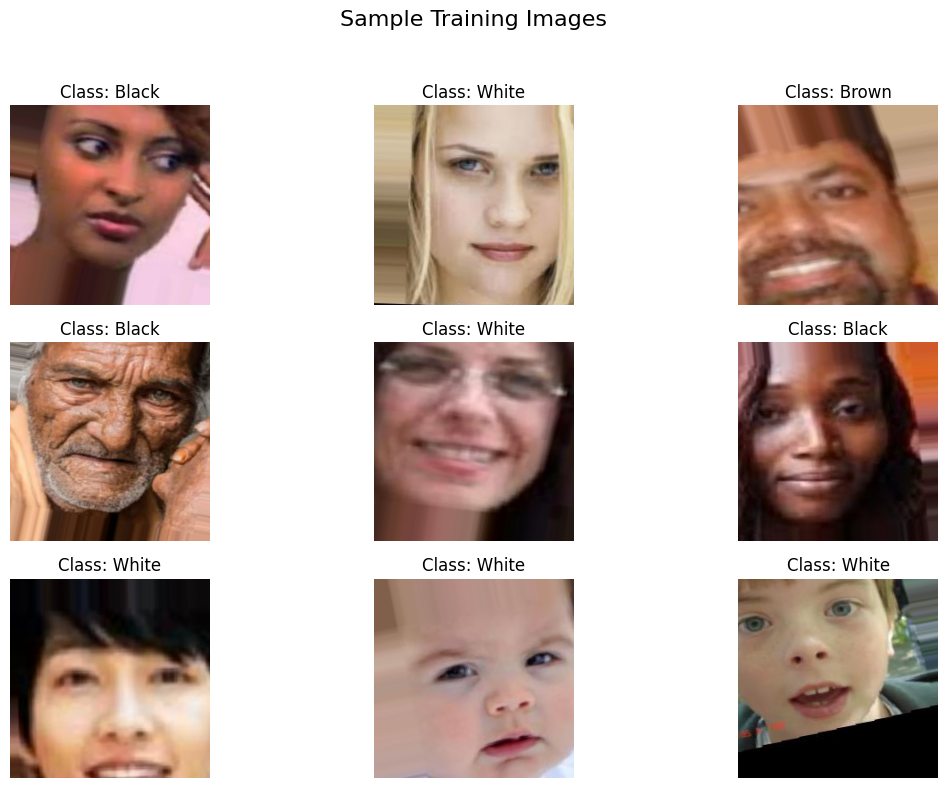

In [20]:
# Cell 5: Visualize Sample Images from the Dataset
def display_sample_images(generator, title):
    """
    Display sample images from a data generator.

    Args:
        generator: Data generator
        title: Title for the plot
    """
    # Get a batch of images
    x_batch, y_batch = next(generator)

    # Create a figure
    plt.figure(figsize=(12, 8))
    plt.suptitle(title, fontsize=16)

    # Display 9 images from the batch
    for i in range(min(9, len(x_batch))):
        plt.subplot(3, 3, i+1)
        plt.imshow(x_batch[i])
        class_idx = np.argmax(y_batch[i])
        class_name = list(class_indices.keys())[list(class_indices.values()).index(class_idx)]
        plt.title(f'Class: {class_name}')
        plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Display sample images from training set
display_sample_images(train_generator, 'Sample Training Images')

In [21]:
# Cell 6: Build the Skin Complexion Classification Model
def build_model(num_classes=NUM_CLASSES):
    """
    Build and compile the skin complexion classification model.

    Args:
        num_classes: Number of output classes

    Returns:
        Compiled model
    """
    # Load MobileNetV2 as base model (without top layers)
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)  # Add dropout to prevent overfitting
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Build the model
skin_complexion_model = build_model()

# Print model summary
skin_complexion_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [22]:
# Cell 7: Set Up Callbacks for Training
# Define callbacks
checkpoint_path = os.path.join(OUTPUT_DIR, "skin_complexion_model_best.h5")
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

callbacks = [checkpoint_callback, early_stopping]

In [23]:
# Cell 8: Train the Model
# Calculate steps per epoch and validation steps
steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

# Train the model
history = skin_complexion_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4078 - loss: 1.3109
Epoch 1: val_accuracy improved from -inf to 0.72000, saving model to ./models/skin_complexion/skin_complexion_model_best.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.4102 - loss: 1.3043 - val_accuracy: 0.7200 - val_loss: 0.7080
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6745 - loss: 0.7702
Epoch 2: val_accuracy improved from 0.72000 to 0.73778, saving model to ./models/skin_complexion/skin_complexion_model_best.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.6742 - loss: 0.7704 - val_accuracy: 0.7378 - val_loss: 0.6205
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6818 - loss: 0.6978
Epoch 3: val_accuracy improved from 0.73778 to 0.79111, saving model to ./models/skin_complexion/skin_complexion_model_best.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6815 - loss: 0.6984 - val_accuracy: 0.7911 - val_loss: 0.5958
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7084 - loss: 0.6947
Epoch 4: val_accuracy did not improve from 0.79111
33/33 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.7079 - loss: 0.6949 - val_accuracy: 0.7778 - val_loss: 0.5593
Epoch 5/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7160 - loss: 0.6505
Epoch 5: val_accuracy did not improve from 0.79111
33/33 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.7158 - loss: 0.6507 - val_accuracy: 0.7644 - val_loss: 0.5689
Epoch 6/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7185 - loss: 0.6948
Epoch 6: val_accuracy did not improve from 0.79111
33/33 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7188 - loss: 0.6937 - val_accuracy: 0.7422 - val_loss: 0.5307
Epoch 7/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7251 - loss: 0.5895
Epoch 7: val_accuracy did not improve from 0.79111
33/3

33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7954 - loss: 0.4746 - val_accuracy: 0.8133 - val_loss: 0.4819
Restoring model weights from the end of the best epoch: 15.


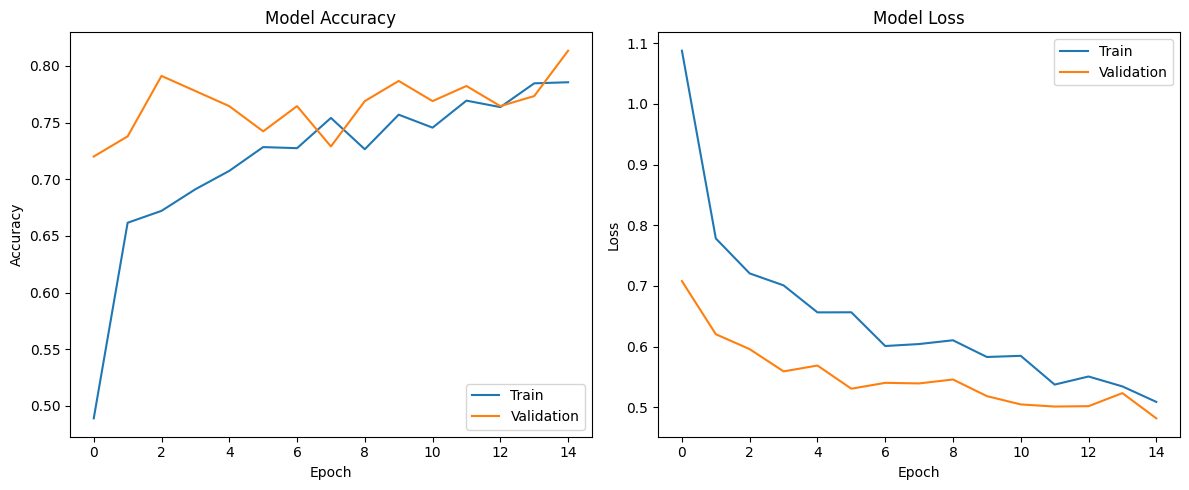

In [24]:
# Cell 9: Visualize Training History
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [25]:
# Cell 10: Evaluate Model on Test Data
# Evaluate the model on test data
test_loss, test_accuracy = skin_complexion_model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions for test data
test_generator.reset()
y_pred_probs = skin_complexion_model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = test_generator.classes

# Generate classification report
class_labels = list(class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)
print("\nClassification Report:")
print(report)

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7416 - loss: 0.5485
Test Loss: 0.5448
Test Accuracy: 0.7422
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step

Classification Report:
              precision    recall  f1-score   support

       Black       0.73      0.79      0.76        75
       Brown       0.65      0.60      0.62        75
       White       0.84      0.84      0.84        75

    accuracy                           0.74       225
   macro avg       0.74      0.74      0.74       225
weighted avg       0.74      0.74      0.74       225



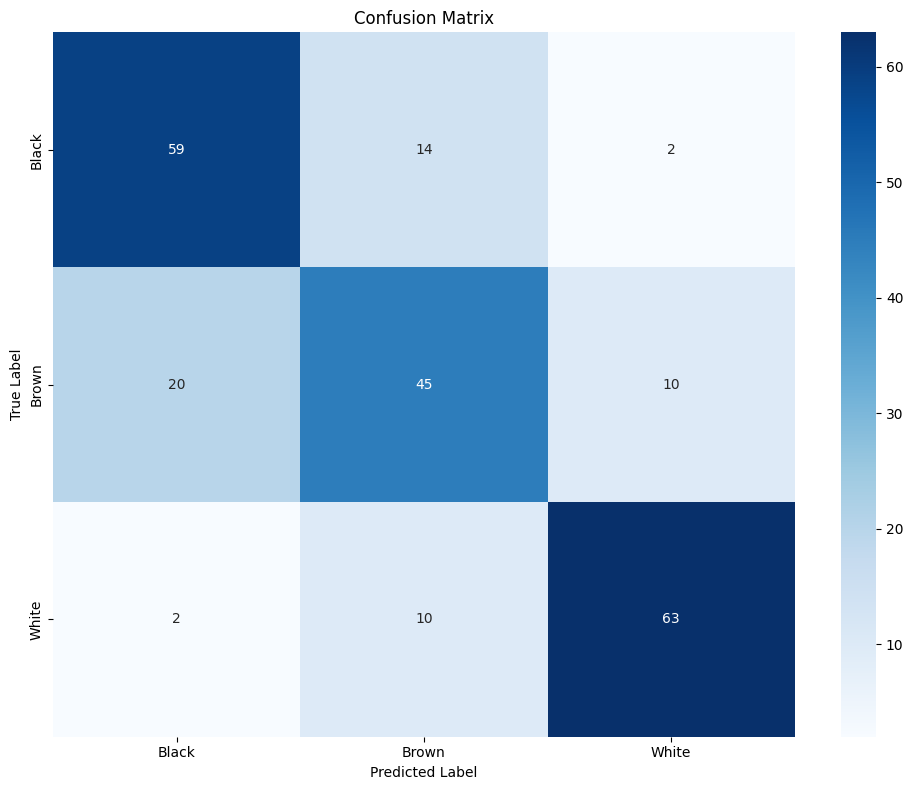

In [26]:
# Cell 11: Plot Confusion Matrix
# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [29]:
# Cell 12: Fine-tune Model (Optional)
# Unfreeze some layers of the base model for fine-tuning
base_model = skin_complexion_model.layers[0]  # Get the base model

# Unfreeze the last 23 layers (about 20% of MobileNetV2)
for layer in base_model.layers[-23:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
skin_complexion_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary to see trainable parameters
skin_complexion_model.summary()

# Fine-tune the model
fine_tuning_history = skin_complexion_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,  # Additional epochs for fine-tuning
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

AttributeError: 'InputLayer' object has no attribute 'layers'

In [ ]:
# Cell 13: Save the Final Model
# Save the model
final_model_path = os.path.join(OUTPUT_DIR, "skin_complexion_model_final.h5")
skin_complexion_model.save(final_model_path)
print(f"Model saved to {final_model_path}")

In [ ]:
'''# Cell 14: Test with Custom Images
def predict_skin_complexion(image_path):
    """
    Predict skin complexion for a given image.

    Args:
        image_path: Path to the image file

    Returns:
        Predicted class and probability
    """
    # Preprocess the image
    img = preprocess_image(image_path)
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Make prediction
    prediction = skin_complexion_model.predict(img)[0]

    # Get the predicted class and probability
    predicted_class_idx = np.argmax(prediction)
    predicted_class = list(class_indices.keys())[list(class_indices.values()).index(predicted_class_idx)]
    probability = prediction[predicted_class_idx]

    return predicted_class, probability

# Test with a sample image (replace with your test image path)
test_image_path = "path/to/your/test/image.jpg"
try:
    # Display the image
    img = cv2.imread(test_image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')

    # Make prediction
    predicted_class, probability = predict_skin_complexion(test_image_path)
    plt.title(f'Predicted: {predicted_class} (Probability: {probability:.2f})')
    plt.show()

    print(f"Predicted skin complexion: {predicted_class}")
    print(f"Probability: {probability:.4f}")
except Exception as e:
    print(f"Error: {e}")'''

In [ ]:
'''# Cell 15: Batch Prediction Function for Multiple Test Images
def batch_predict(image_paths):
    """
    Predict skin complexion for multiple images.

    Args:
        image_paths: List of paths to image files

    Returns:
        DataFrame with results
    """
    results = []

    for path in image_paths:
        try:
            # Get filename
            filename = os.path.basename(path)

            # Preprocess and predict
            predicted_class, probability = predict_skin_complexion(path)

            # Add to results
            results.append({
                'Filename': filename,
                'Predicted Class': predicted_class,
                'Probability': probability
            })

        except Exception as e:
            print(f"Error processing {path}: {e}")
            results.append({
                'Filename': os.path.basename(path),
                'Predicted Class': 'Error',
                'Probability': 0.0
            })

    # Create DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Example usage (replace with your actual test images)
test_image_paths = [
    "path/to/test_image1.jpg",
    "path/to/test_image2.jpg",
    "path/to/test_image3.jpg",
    # Add more images here
]

# Make predictions for test images
# Uncomment when you have test images ready
# results_df = batch_predict(test_image_paths)
# print(results_df)'''